# Arbitrary Pulse Generation Demo

This notebook demonstrates the construction and use of all the types of arbitrary pulses that may be generated.

IQ data is sampled at the maximum sampling frequency of the DAC (9830.4 MHz).

`outsel='product'` pulses multiply IQ data by the DDS (sinusoidal oscillations) output.

`outsel='input'` pulses output the raw I data.

`sequence` type arbitrary pulses take a user-input of a list of tuples containing pulse parameters in the form `sequence=[(pulse_duration, amplitude, frequency, phase), ...]`

`samples` type arbitrary pulses take a user-input of a list whereby index 0 is a list of I samples and index 1 is a list of Q samples.

In [1]:
# Import libraries
%load_ext autoreload
%autoreload 2

from rfsoc_lib.rfsoc_pulses import RfsocPulses
from rfsoc_lib.rfsoc_arb_pulses import RfsocArbPulses

import pickle
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Board libraries
from qick import *
import Pyro4

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "172.24.106.21" # <-- SET IP ADDRESS
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)


QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by o

In [4]:
# Import constant EOM voltage calibration
with open('pickles/const_power_test.pickle', 'rb') as handle:
    const_power = pickle.load(handle)

In [60]:
# Generate some IQ data

samples = [[], []]
for i in range(196):
    samples[0].append(-32566)
    samples[1].append(0)
for i in range(98):
    samples[0].append(0)
    samples[1].append(0)
for i in range(196):
    samples[0].append(32566/np.sqrt(2))
    samples[1].append(32566/np.sqrt(2))

In [93]:
# Define arbitrary pulses

# ------ SEQUENCE PRODUCT TYPE ------
# Frequency: FIXED (DDS)
# Phase: Variable
# Amplitude: Variable
sequence_product = RfsocArbPulses(soccfg,
                                  sequence=[(20, 1.0, 0.2, 0), (10, 0), (20, 0.5, 0.2, 180)],
                                  outsel='product',
                                  )

# ------ SEQUENCE INPUT TYPE -------
# Frequency: Variable
# Phase: Variable
# Amplitude: Variable
sequence_input = RfsocArbPulses(soccfg,
                                sequence=[(20, 1.0, 0.2, 0), (10, 0), (20, 1.0, 0.1, 0)],
                                outsel='input',
                                )


# ------ SAMPLES PRODUCT TYPE ------
# IQ data set by user
# Frequencey: FIXED (DDS)
samples_product = RfsocArbPulses(soccfg,
                                 samples=samples,
                                 outsel='product',
                                 freq=0.2
                                 )

# ------ SAMPLES INPUT TYPE -----
# IQ data set by user
# Q data ignored
samples_input = RfsocArbPulses(soccfg,
                               samples=samples,
                               outsel='input',
                               )

# Assemble sequence
dac_seq = [(20, 1.0, 0.1, 0), (10, 0), sequence_product, (10, 0), sequence_input, (10, 0), samples_product, (10, 0), samples_input]

# Assign sequence to DAC_A and trigger digital pulse
sequences = {'DAC_A': dac_seq, 'DIG_0': [(10, 1)]}

# Channel parameters
delays = {"DAC_A": 0, "DIG_0": 38}
gains = {'DAC_A': 32766/2}

pulses = RfsocPulses(sequences,
                     delays=delays,
                     gains=gains,
                     const_power=const_power,
                     scale_power=1,
                     print_params=True
                     )

# Try commenting out const_power or changing const_power to see effects on DAC amplitude


---------- DAC A ----------
CONFIG
	ch_type: DAC
	ch_index: 1
	delay: 0
	num_pulses: 5
	duration: 0.26
PULSES
	lengths: [0.02, 0.05, 0.05, 0.05, 0.05]
	times: [0.0, 0.03, 0.09, 0.15, 0.21]
	amps: [1.0, None, None, None, None]
	gains: [10000, 20000, 20000, 20000, 20000]
	freqs: [100.0, 200.0, 0.0, 200.0, 0.0]
	phases: [0.0, None, None, None, None]
	styles: ['const', 'arb', 'arb', 'arb', 'arb']
	outsels: [None, 'product', 'input', 'product', 'input']

---------- DIG 0 ----------
CONFIG
	ch_type: DIG
	ch_index: 0
	delay: 38
	num_pulses: 1
	duration: 0.01
PULSES
	lengths: [0.01]
	times: [0.0]

END TIME: 0.26


In [103]:
# Generate assembly
prog = QickProgram(soccfg)
pulses.generate_asm(prog, reps=1)

# Configure external start
# pulses.config_external_start(soc, prog)

# Configure internal start and run
pulses.config_internal_start(soc, prog)
soc.tproc.start() # Run program

# Print assembly
print(prog)


// Program

        synci 200;
        regwi 0, $14, 0;
LOOP_I: regwi 1, $22, 43690667;                 //freq = 43690667
        regwi 1, $23, 0;                        //phase = 0
        regwi 1, $25, 10000;                    //gain = 10000
        regwi 1, $26, 589836;                   //phrst| stdysel | mode | | outsel = 0b01001 | length = 12 
        regwi 1, $27, 0;                        //t = 0
        set 1, 1, $22, $23, $0, $25, $26, $27;  //ch = 1, pulse @t = $27
        regwi 1, $22, 87381333;                 //freq = 87381333
        regwi 1, $23, 0;                        //phase = 0
        regwi 1, $25, 20000;                    //gain = 20000
        regwi 1, $24, 0;                        //addr = 0
        regwi 1, $26, 524319;                   //phrst| stdysel | mode | | outsel = 0b01000 | length = 31 
        regwi 1, $27, 12;                       //t = 12
        set 1, 1, $22, $23, $24, $25, $26, $27; //ch = 1, pulse @t = $27
        regwi 1, $22, 0;       

## Expected Output

![](images/arb_sequence.png)

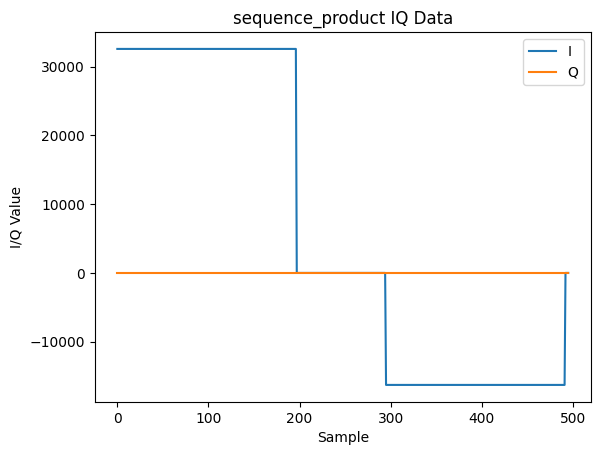

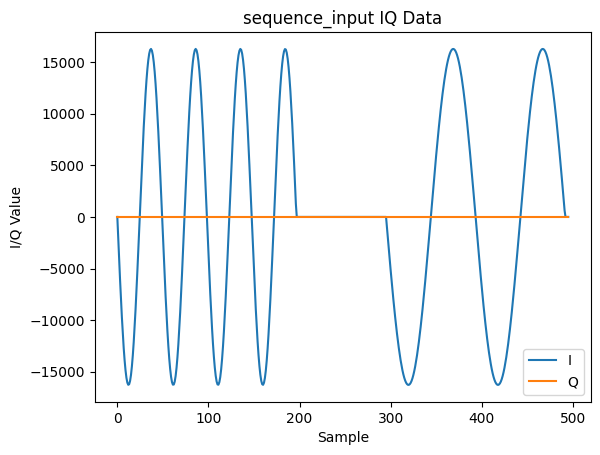

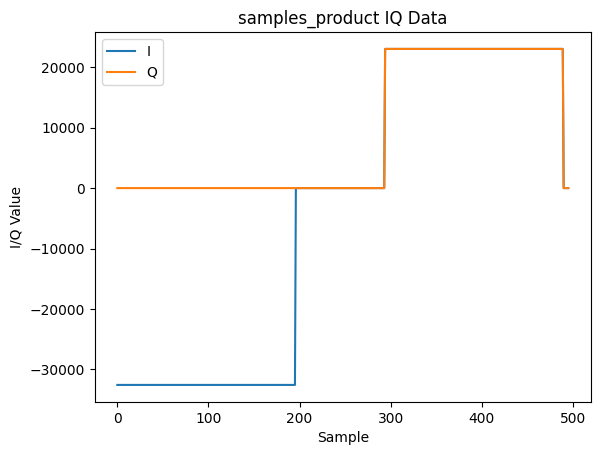

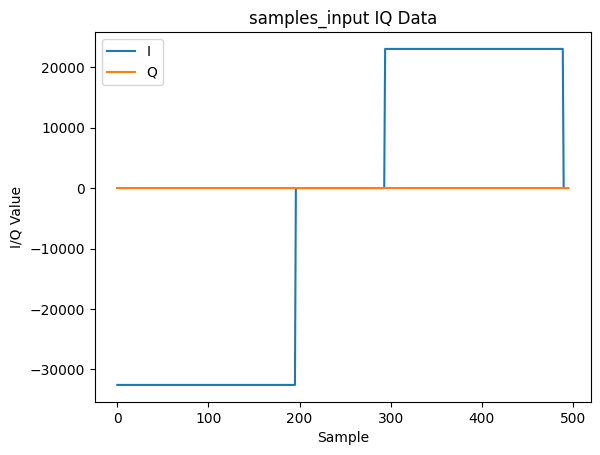

In [102]:
# Plot IQ data for each arb. pulse

plt.title("sequence_product IQ Data")
plt.plot(sequence_product.idata, label="I")
plt.plot(sequence_product.qdata, label="Q")
plt.xlabel("Sample")
plt.ylabel("I/Q Value")
plt.legend()
plt.show();

plt.title("sequence_input IQ Data")
plt.plot(sequence_input.idata, label="I")
plt.plot(sequence_input.qdata, label="Q")
plt.xlabel("Sample")
plt.ylabel("I/Q Value")
plt.legend()
plt.show();

plt.title("samples_product IQ Data")
plt.plot(samples_product.idata, label="I")
plt.plot(samples_product.qdata, label="Q")
plt.xlabel("Sample")
plt.ylabel("I/Q Value")
plt.legend()
plt.show();

plt.title("samples_input IQ Data")
plt.plot(samples_input.idata, label="I")
plt.plot(samples_input.qdata, label="Q")
plt.xlabel("Sample")
plt.ylabel("I/Q Value")
plt.legend()
plt.show();